## Training a Deep Averaging Neural Network Model with Keras in Tensorflow

In this project, you will implement a Deep Averaging Network for sentiment classification. 

This will involve the following steps:

1. Load the data set
2. Create a "featurizer"
3. Construct the deep averaging neural network
4. Train the model
5. Evaluate the model

Use the other Neural Network implementations that you have seen this week as guides for completing this exercise.

To get started, let us import the libraries we need.

In [113]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.keras as keras
import tensorflow as tf
from sklearn.feature_extraction.text import CountVectorizer

###  Load the Data Set

We will use the <a href=https://www.cs.jhu.edu/~mdredze/datasets/sentiment/>multi-domain sentiment</a> data set created by Professor <a href=https://www.cs.jhu.edu/~mdredze/>Mark Dredze</a> for our project. This data set contains product reviews taken from Amazon.com from many product types. The product reviews are labeled as positive or negative. In this exercise, we will only consider book reviews. To make things simpler, we also created a dictionary `vocab` that contains words that will be considered when constructing the word embedding for the deep averaging network. Run the following two cells to load the data and see a positive and a negative review:

In [114]:
review_train = pd.read_csv('review_train.csv')
review_test = pd.read_csv('review_test.csv')
vocab = np.load('vocabulary.npy', allow_pickle=True).item()

# class 1 == Positive reviews
# class 0 == Negative reviews
label_meaning = ['Negative', 'Positive']

print('Number of Training Reviews: ', review_train.shape[0])
print('Number of Test Reviews: ', review_test.shape[0])
print('Number of Words in the Vocabulary: ', len(vocab))

Number of Training Reviews:  1787
Number of Test Reviews:  200
Number of Words in the Vocabulary:  4380


In [115]:
# print some training reviews
print('A Positive Training Review: \n\n', review_train.iloc[0]['review'])
print('A Negative Training Review: \n\n', review_train.iloc[-1]['review'])

A Positive Training Review: 

 This was perhaps the best of Johannes Steinhoff's books, since it does not  deal with his own stellar yet tragic WW II and post war career. The  insights of the average person living in Germany are of great importance to  both social and military historians alike. Steinhoff offered this  collective testament as a warning to all of us regarding war and the rise  of a dictator. As Johannes said in an interview, &quot;It is always the  civilians who suffer the most, yet are remembered the least.&quot

A Negative Training Review: 

 I got to page 26 and gave up.  Lockes writings lack focus and are void of humour.  I read as much as I could with patience until it became clear this book was simply someone rambling on about nothing.  Save your money for something worth reading



### Create Word Embeddings from our Data Set

We wll create a featurizer to convert the input text to feature vectors. We will use a function from <code>sklearn</code> called <code>CountVectorizer</code> that creates word embeddings for us. It creates a featurizer that takes in a vocabulary and return a **bag of words featurizer** based on the vocabulary. Using the returned featurizer, you can convert a sentence into a bag of words feature vector. See the code cell below for an example on how to use the <code>CountVectorizer</code>:

In [116]:
# Create a simple vocabulary
simple_vocab = {'learn': 0, 'machine': 1, 'learning': 2, 'teach': 3}

# Create a simple sentence that will be converted into bag of words features
simple_sentence = ' I learn machine learning to teach machine how to learn.'

# Create a featurizer by passing in the vocabulary to CountVectorizer
simple_featurizer = CountVectorizer(vocabulary = simple_vocab)

# Call simple_featurizer.transform to transform the sentence to its bag of word features
output = simple_featurizer.transform([simple_sentence]).toarray()
print(output)

[[2 2 1 1]]


You should have gotten the array `[[2, 2, 1, 1]]` as output.
This means that the sentence has 2 occurences of 'learn', 2 occurences of 'machine', 
1 occurence of 'learning' and 1 occurence of 'teach'

In the code cell below, we will use <code>CountVectorizer</code> to generate a featurizer based on the vocabulary we provided in the `vocab` dictionary.

In [117]:
# Use the given vocab to generate bag of words featurizer
bow_featurizer = CountVectorizer(vocabulary = vocab)

### Create Training and Test Sets

In the code cell below, we will use the featurizer to convert the training reviews and test reviews into bag of word representations that we can use to train and test our model.

In [118]:
# convert the reviews to bow representation and tf Tensor
x_train = bow_featurizer.transform(review_train['review'].values).toarray() 
y_train = review_train['label'].values.flatten()
x_test = bow_featurizer.transform(review_test['review'].values).toarray()
y_test = review_test['label'].values.flatten()

### Step 1.  Define Model Structure

Like we did in the previous projects, we will use the `Sequential` class to create our neural network structure. But performing the averaging step is tricky in Keras, as it does not give us control over how forward propagation is performed. The solution to this problem is to define our own averaging layer in Tensorflow and Keras, which can be included in `Sequential` when creating the model. We will do this by creating a class `KerasAveragingLayer` in the code cell below. Make sure to execute the cell below in order to use the class in subsequent cells.

In [119]:
# Define our own averaging layer class in Keras
class KerasAveragingLayer(keras.layers.Layer):
    def __init__(self, vocab_size, embedding_size=32):
        super().__init__()
        self.embeds = self.add_weight(
            'embeds', shape=[vocab_size, embedding_size]
        )

    def call(self, x):
        return tf.matmul(x, self.embeds) / tf.reduce_sum(x, axis=1, keepdims=True)
    

In the code cell below we define the model structure using the `Sequential` class and our custom `KerasAveragingLayer` class.

In [120]:
model = keras.Sequential()

input_layer = keras.layers.InputLayer(len(vocab)) # define input layer
model.add(input_layer)
averaging_layer = KerasAveragingLayer(len(vocab), embedding_size=32)
model.add(averaging_layer)
output_layer = keras.layers.Dense(2, activation=None)
model.add(output_layer)

### Step 2. Define the Optimization Function

In the code cell below, create a stochastic gradient descent `SGD` optimizer with a learning rate of 5 and assign the result to a variable called `optimizer`.

### Graded Cell

In [121]:
optimizer = keras.optimizers.SGD(learning_rate=5)

### Self-Check
Run the cell below to test the correctness of your code above before submitting for grading.

In [122]:
# Run this self-test cell to check your code; do not add code or delete code in this cell
from jn import testoptimizer
try:
    print(testoptimizer(optimizer))
except Exception as e:
    print("Error!\n" + str(e))


Correct!


### Step 3. Define the loss function

In the code cell below, create a `SparseCategoricalCrossentropy` loss function with the argument `from_logits=True`, and assign the result to a variable called `loss_fn`.

### Graded Cell

In [123]:
loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=True)

### Self-Check
Run the cell below to test the correctness of your code above before submitting for grading.

In [124]:
# Run this self-test cell to check your code; do not add code or delete code in this cell
from jn import testlossfn
try:
    print(testlossfn(loss_fn))
except Exception as e:
    print("Error!\n" + str(e))


Correct!


### Step 4. Compile the Model

In the code cell below, package the network architecture with the optimizer and the loss function using the `.compile()` method. Include the `metrics` parameter with the value `accuracy`.

### Graded Cell

In [125]:
model.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])

### Self-Check
Run the cell below to test the correctness of your code above before submitting for grading.

In [126]:
# Run this self-test cell to check your code; do not add code or delete code in this cell
from jn import testmodel
try:
    print(testmodel(model))
except Exception as e:
    print("Error!\n" + str(e))


Correct!


### Step 5. Train the Model

As before, we will define our own callback class to output information from our model while it is training. Make sure you execute the code cell below so that it can be used in subsequent cells.

In [127]:
class ProgBarLoggerNEpochs(tf.keras.callbacks.Callback):
    
    def __init__(self, num_epochs: int, every_n: int = 50):
        self.num_epochs = num_epochs
        self.every_n = every_n
    
    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.every_n == 0:
            s = 'Epoch [{}/ {}]'.format(epoch + 1, self.num_epochs)
            logs_s = ['{}: {:.4f}'.format(k.capitalize(), v)
                      for k, v in logs.items()]
            s_list = [s] + logs_s
            print(', '.join(s_list))


In the code cell below, run the `.fit()` method on the model to learn parameters from the training data and save the output to variable `history`. In addition to passing in the training data `x_train` and `y_train` as arguments, specify the following parameters:

* set `epochs` to equal M
* set `steps_per_epoch` to equal 5
* set `batch_size` to equal 128
* set `verbose` to 0
* set `callbacks` to a list containing our logger function`ProgBarLoggerNEpochs(M, every_n=100)`  


### Graded Cell

<i>Note: a self-check will not accompany this exercise</i>

In [128]:
M = 1000 # number of epochs

history = model.fit(
    x_train,
    y_train,
    steps_per_epoch = 5,
    batch_size = 128,
    epochs=M,
    verbose=0, # disable the default progress bar
    callbacks=[ProgBarLoggerNEpochs(M, every_n=100)],
)

Epoch [100/ 1000], Loss: 0.5441, Accuracy: 0.7234
Epoch [200/ 1000], Loss: 0.2345, Accuracy: 0.9203
Epoch [300/ 1000], Loss: 0.1033, Accuracy: 0.9669
Epoch [400/ 1000], Loss: 0.0840, Accuracy: 0.9734
Epoch [500/ 1000], Loss: 0.0285, Accuracy: 0.9969
Epoch [600/ 1000], Loss: 0.0129, Accuracy: 1.0000
Epoch [700/ 1000], Loss: 0.0088, Accuracy: 1.0000
Epoch [800/ 1000], Loss: 0.0066, Accuracy: 1.0000
Epoch [900/ 1000], Loss: 0.0040, Accuracy: 1.0000
Epoch [1000/ 1000], Loss: 0.0040, Accuracy: 1.0000


The model will likely train quickly, reaching 100% accuracy in a few-hundred epochs. We can plot the training losses to check.

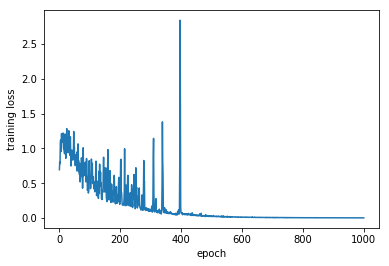

In [129]:
plt.plot(np.arange(M) + 1, history.history['loss'])
plt.xlabel('epoch')
plt.ylabel('training loss')
plt.show()

### Step 6. Evaluate the Model

In the code cell below, use the `.evaluate()` method on the test set (`x_test` and `y_test`) to get a sense of how our model will generalize to new data. The `.evaluate()` method returns two values: the first is loss and the second is accuracy. Save the results to variables `loss` and `accuracy` and print these results.

### Graded Cell

In [130]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
print('Loss: ', str(loss) , 'Accuracy: ', str(accuracy))

Loss:  0.6159882545471191 Accuracy:  0.9049999713897705


### Self-Check
Run the cell below to test the correctness of your code above before submitting for grading.

In [131]:
# Run this self-test cell to check your code; do not add code or delete code in this cell
from jn import testlossacc
try:
    print(testlossacc(model, x_test, y_test, loss, accuracy))
except Exception as e:
    print("Error!\n" + str(e))


Correct!


In the code cell below, make a prediction on our test data. We will later analyze for ourselves whether the prediction is accurate.

1. Use the `.predict()` method to make a prediction on `x_test` and save the results to variable `1ogits`.

2. Next, use method `.argmax(axis=1)` to convert `logits` to predicted labels, and save the results to variable `pred`.

### Graded Cell

In [132]:
# Evaluate the network
# Make predictions on the test set
logits = model.predict(x_test)
pred = logits.argmax(axis = 1)

print("Predictions for the first 5 data points:")
print("Logits\t\t\tClass")
for i in range(0,5):
    print(str(logits[i]) + "\t" + str(pred[i]))

Predictions for the first 5 data points:
Logits			Class
[-7.282077   7.2656555]	1
[-3.1004603  3.0962598]	1
[-4.815721  4.804714]	1
[-1.1063694  1.0996342]	1
[-7.725144  7.719185]	1


### Self-Check
Run the cell below to test the correctness of your code above before submitting for grading.

In [133]:
# Run this self-test cell to check your code; do not add code or delete code in this cell
from jn import testpred
try:
    print(testpred(model, x_test, logits, pred))
except Exception as e:
    print("Error!\n" + str(e))


Correct!


To examine an individual test case we can print out the 20th row of the test data set and see how our model classified it. Remember that label 1 refers to a positive review and label 0 to a negative review. The code cell below prints out the review and the predicted lablel. How did we do on this one?

In [134]:
print('Input: \n\n ',review_test.iloc[20]['review'])

label = pred[20]
print('\nModel prediction: ')
if label == 1:
    print('Positive')
else:
    print('Negative')

Input: 

  I'm almost finished reading this book, and what a long, fun ride it's been.  Wordy, and a little confusing, this book has to be taken in the right mood, or else you'll miss the humor.

The places that the main character travels to are memorable and exciting, and I found myself getting through a hefty portion, without thinking that I had ever started.

Some....no, more like most of the satire is cryptic, and hard to find.  However, I read up on the book, and it immediately popped out at me, and made alot more sense.

This is an excellent book, that I'm sure you will enjoy.  It might even suit as a read-aloud story for younger children


Model prediction: 
Positive
